In [1]:
import os
import torch
import time
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" # optional setting for faster dataset downloads
dataset = load_dataset("davanstrien/ufo-ColPali", split="train")

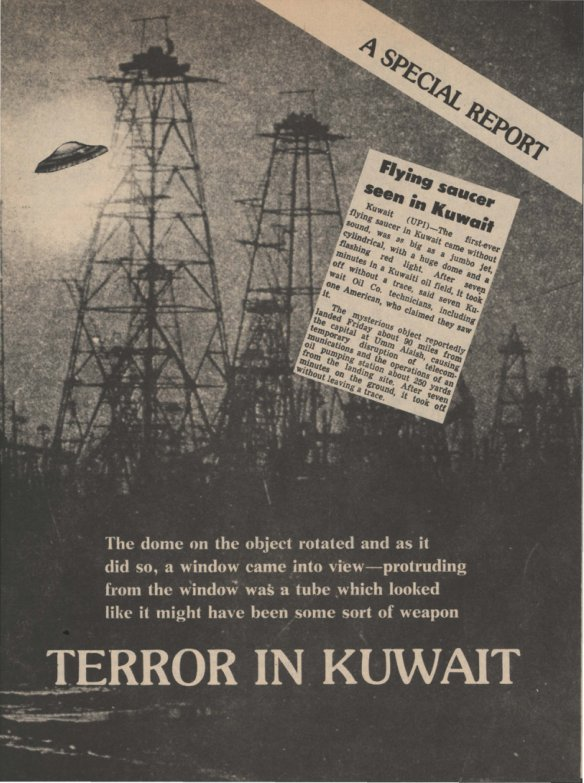

In [2]:
dataset[439]["image"]

In [4]:
# Define the path for the Qdrant database within your project directory
db_path = os.path.join(os.getcwd(), "qdrant_local_db")

# Initialize the Qdrant client with the specified local database path
qdrant_client = QdrantClient(path=db_path)

In [5]:
from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = (
    "davanstrien/finetune_colpali_v1_2-ufo-4bit"  # Use the latest version available
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="mps",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
query_text = "top secret"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [7]:
start_time = time.time()

collection_name = "ufo-binary"

search_result = qdrant_client.query_points(
    collection_name=collection_name,
    query=multivector_query,
    limit=10,
    timeout=100,
    search_params=models.SearchParams(
        quantization=models.QuantizationSearchParams(
            ignore=False,
            rescore=True,
            oversampling=2.0,
        )
    )
)
end_time = time.time()
# Search in Qdrant
search_result.points

elapsed_time = end_time - start_time
print(f"Search completed in {elapsed_time:.4f} seconds")

Search completed in 0.3901 seconds


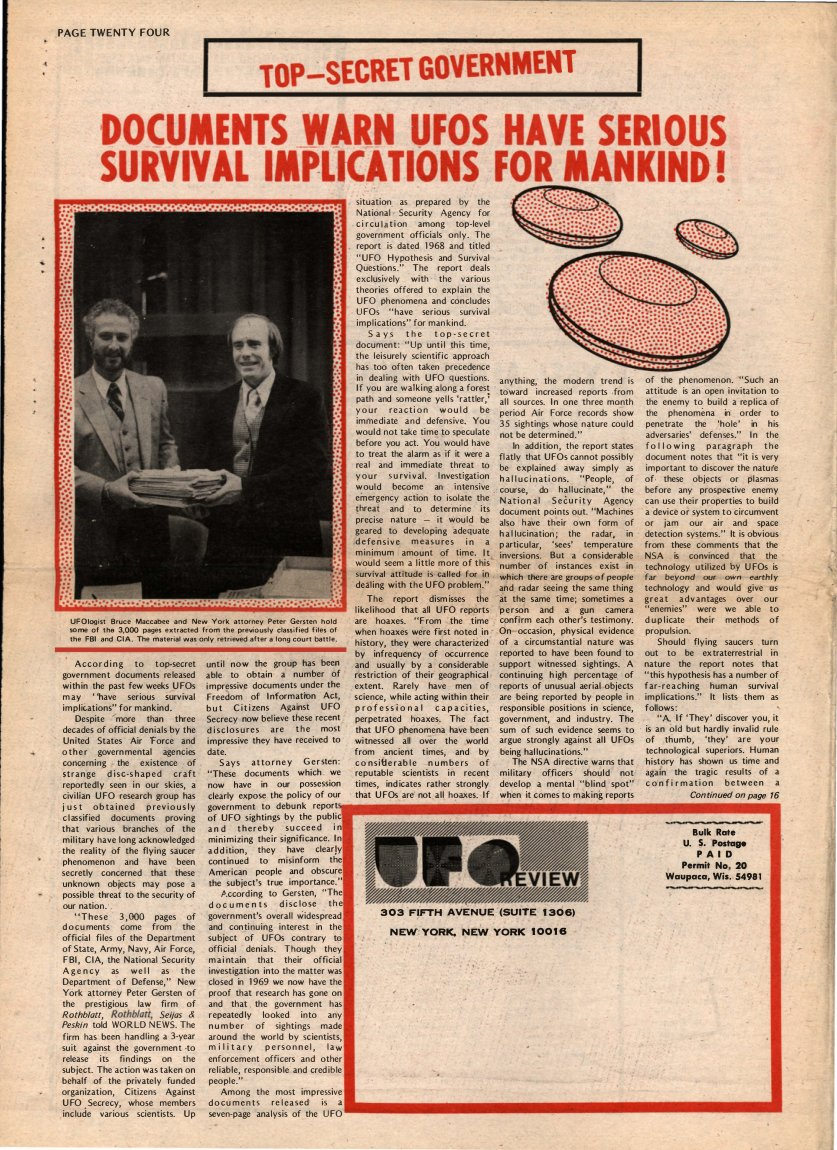

In [8]:
idx = search_result.points[0].id
dataset[idx]["image"]

In [3]:
import base64
from openai import OpenAI
from io import BytesIO
from PIL import Image

# Extract an image from the dataset
image = dataset[439]["image"]  # Replace 439 with the index of the image you want to use

# Convert the image to base64
def image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")  # Save the image in JPEG format
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

# Encode the image
encoded_image = image_to_base64(image)

In [4]:
# Point to the local server
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

# Set up the request with stream=True and include the base64-encoded image
response = client.chat.completions.create(
    model="qwen2-vl-7b-instruct",  # Ensure this matches the model name on your local server
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What's in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encoded_image}",
                    },
                },
            ],
        }
    ],
    max_tokens=300,
    stream=True  # Enable streaming
)

# Process the streamed response
for chunk in response:
    if chunk.choices[0].delta.content:
        print(chunk.choices[0].delta.content, end="", flush=True)

The image appears to be a page from a magazine or book, featuring an article titled "A Special Report." The main focus of the page is a UFO (unidentified flying object) flying over an oil rig in Kuwait. The text describes the sighting of a flying saucer and mentions that it had a dome on its object, which rotated. The report suggests that the dome contained a window from which a tube-like weapon was protruding, indicating some form of advanced technology or weaponry. The overall theme of the page is a sensational report on an extraterrestrial encounter in Kuwait.